In [1]:
basedir = '/home/abhinavgupta0110/NeuralODEs_ROM_Closure'

import os

is_google_colab = False
is_use_GPU = False

### Mount the drive

In [2]:
if is_use_GPU:
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('No GPU found!')
    else:
        print(gpu_info)

if is_google_colab:
    from google.colab import drive
    drive.mount('/content/drive')

    %pip install quadpy
    
os.chdir(os.path.join(basedir, 'neuralDDE_ROM_Closure'))

### Load modules

In [3]:
from src.utilities.DDE_Solver import ddeinttf 
import src.advec_diff_case.advec_diff_eqn as adeq
import src.advec_diff_case.rom_advec_diff as rom
import src.solvers.neuralDDE_with_adjoint as ndde

from IPython.core.debugger import set_trace

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import pickle

tf.keras.backend.set_floatx('float32')

## Load data

In [4]:
os.chdir(basedir)

with open(os.path.join('neuralDDE_ROM_Closure/final_paper_scripts', 'baseline_Exp1_extended.pkl'), 'rb') as output:
    true_ai_red = pickle.load(output)
    ai_whole = pickle.load(output)
    t = pickle.load(output)
    
with open(os.path.join('neuralDDE_ROM_Closure/final_paper_scripts', 'nODE_Exp1_extended.pkl'), 'rb') as output:
    pred_y_whole_nODE = pickle.load(output)
    
with open(os.path.join('neuralDDE_ROM_Closure/final_paper_scripts', 'nDDE_Exp1_extended.pkl'), 'rb') as output:
    pred_y_whole_nDDE = pickle.load(output)
    
with open(os.path.join('neuralDDE_ROM_Closure/final_paper_scripts', 'nDistDDE_Exp1_extended.pkl'), 'rb') as output:
    pred_y_whole_nDistDDE = pickle.load(output)

## Plot Signed Differences

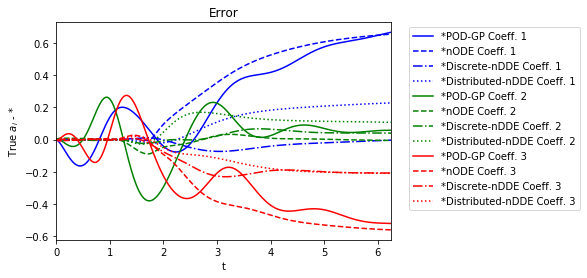

In [5]:
diff_colors = ['b', 'g', 'r', 'k', 'c', 'm']
rom_dims = 3

fig = plt.figure(figsize=(6, 4), facecolor='white')
ax = fig.add_subplot(111)

ax.cla()
ax.set_title('Error')
ax.set_xlabel('t')
ax.set_ylabel('True $a_i$ - *')
ax.set_xlim(min(t.numpy()), max(t.numpy()))
# ax.set_ylim(-1, 1)

for i in range(rom_dims):
    ax.plot(t.numpy(), true_ai_red[:, 0, i] - ai_whole[:, 0, i], diff_colors[i % rom_dims]+'-', label = '*POD-GP Coeff. '+str(i+1))
    ax.plot(t.numpy(), true_ai_red[:, 0, i] - pred_y_whole_nODE[:, 0, i], diff_colors[i % rom_dims]+'--', label = '*nODE Coeff. '+str(i+1))
    ax.plot(t.numpy(), true_ai_red[:, 0, i] - pred_y_whole_nDDE[:, 0, i], diff_colors[i % rom_dims]+'-.', label = '*Discrete-nDDE Coeff. '+str(i+1))
    ax.plot(t.numpy(), true_ai_red[:, 0, i] - pred_y_whole_nDistDDE[:, 0, i], diff_colors[i % rom_dims]+':', label = '*Distributed-nDDE Coeff. '+str(i+1))

ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show() 

## Plot Unsigned Differences

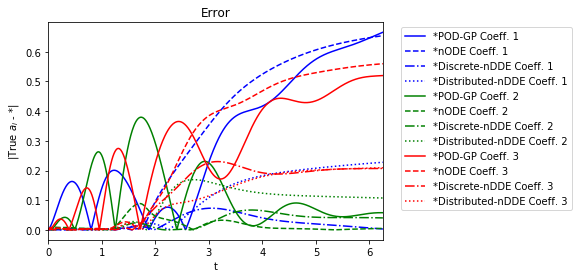

In [6]:
diff_colors = ['b', 'g', 'r', 'k', 'c', 'm']
rom_dims = 3

fig = plt.figure(figsize=(6, 4), facecolor='white')
ax = fig.add_subplot(111)

ax.cla()
ax.set_title('Error')
ax.set_xlabel('t')
ax.set_ylabel('|True $a_i$ - *|')
ax.set_xlim(min(t.numpy()), max(t.numpy()))
# ax.set_ylim(-1, 1)

for i in range(rom_dims):
    ax.plot(t.numpy(), np.abs(true_ai_red[:, 0, i] - ai_whole[:, 0, i]), diff_colors[i % rom_dims]+'-', label = '*POD-GP Coeff. '+str(i+1))
    ax.plot(t.numpy(), np.abs(true_ai_red[:, 0, i] - pred_y_whole_nODE[:, 0, i]), diff_colors[i % rom_dims]+'--', label = '*nODE Coeff. '+str(i+1))
    ax.plot(t.numpy(), np.abs(true_ai_red[:, 0, i] - pred_y_whole_nDDE[:, 0, i]), diff_colors[i % rom_dims]+'-.', label = '*Discrete-nDDE Coeff. '+str(i+1))
    ax.plot(t.numpy(), np.abs(true_ai_red[:, 0, i] - pred_y_whole_nDistDDE[:, 0, i]), diff_colors[i % rom_dims]+':', label = '*Distributed-nDDE Coeff. '+str(i+1))

ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show() 

## Plot RMSE 

In [7]:
POD_GP_error = tf.squeeze(tf.sqrt(tf.reduce_mean(tf.math.squared_difference(true_ai_red, ai_whole), axis=-1)), axis=-1)
nODE_error = tf.squeeze(tf.sqrt(tf.reduce_mean(tf.math.squared_difference(true_ai_red, pred_y_whole_nODE), axis=-1)), axis=-1)
nDDE_error = tf.squeeze(tf.sqrt(tf.reduce_mean(tf.math.squared_difference(true_ai_red, pred_y_whole_nDDE), axis=-1)), axis=-1)
nDistDDE_error = tf.squeeze(tf.sqrt(tf.reduce_mean(tf.math.squared_difference(true_ai_red, pred_y_whole_nDistDDE), axis=-1)), axis=-1)

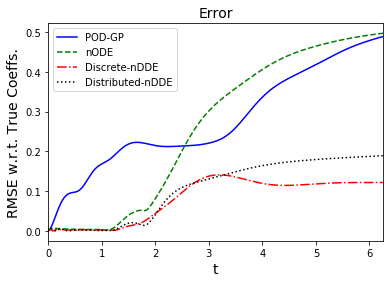

In [12]:
diff_colors = ['b', 'g', 'r', 'k', 'c', 'm']
rom_dims = 3

fig = plt.figure(figsize=(6, 4), facecolor='white')
ax = fig.add_subplot(111)

ax.cla()
ax.set_title('Error', fontsize=14)
ax.set_xlabel('t', fontsize=14)
ax.set_ylabel('RMSE w.r.t. True Coeffs.', fontsize=14)
ax.set_xlim(min(t.numpy()), max(t.numpy()))
# ax.set_ylim(-1, 1)

ax.plot(t.numpy(), POD_GP_error.numpy(), 'b'+'-', label = 'POD-GP ')
ax.plot(t.numpy(), nODE_error.numpy(), 'g'+'--', label = 'nODE')
ax.plot(t.numpy(), nDDE_error.numpy(), 'r'+'-.', label = 'Discrete-nDDE')
ax.plot(t.numpy(), nDistDDE_error.numpy(), 'k'+':', label = 'Distributed-nDDE')

ax.legend(loc="upper left")
plt.show() 